In [1]:
import numpy
%matplotlib notebook
import matplotlib.pyplot
import sympy

# Elliptical Turns

## Overview

At an intersection, a car has to make a smooth turn between two road endpoints. To approximate this effect, I will attempt to fit an ellipse between the two roads. The ellipse must intersect at the endpoint of the intersection and the ellipse must also be tangential to the roads at those points.

## Defining Roads

We can define the roads parametrically in two dimensions. The general equation for a line from point $\langle x_a, y_a \rangle$ to $\langle x_b, y_b \rangle$ in parametric form is

$$ \ell(t) = \langle x_a + (x_b - x_a) t, y_a + (y_b - y_a) t \rangle \quad \forall t \in [0, 1] $$

In particular, we will focus on two perpendicular, linear roads. The first goes from $\langle 3, 2 \rangle$ to $\langle 3, 3 \rangle$. The second from $\langle 4, 4 \rangle$ to $\langle 5, 4 \rangle$. These are defined by the equations

$$ \ell_a(t) = \langle 3, 2 + t \rangle \quad \forall t \in [0, 1] $$
$$ \ell_b(t) = \langle 4 + t, 4 \rangle \quad \forall t \in [0, 1] $$ 

In [2]:
# Each component must have a dependence on `t` for NumPy to broadcast correctly
l_a = lambda t: numpy.array([[3 + 0 * t], [2 + t]])
l_b = lambda t: numpy.array([[4 + t], [4 + 0 * t]])

Now we can visualize the problem a little better by plotting the roads.

<IPython.core.display.Javascript object>


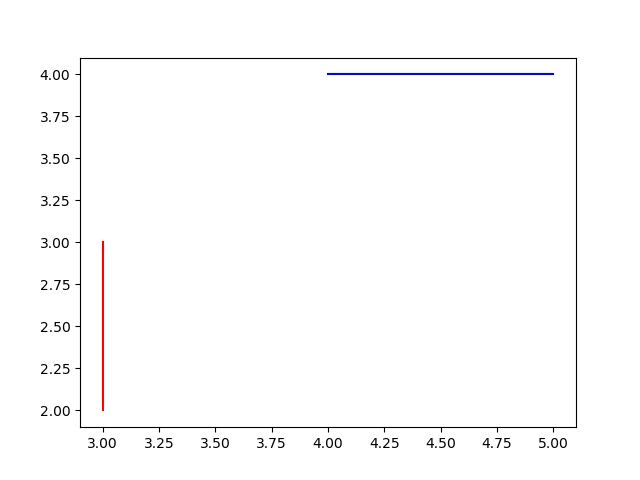

In [3]:
fig, ax = matplotlib.pyplot.subplots()

t_a = t_b = numpy.linspace(0, 1, 100)

ax.plot(l_a(t_a)[0].flatten(), l_a(t_a)[1].flatten(), 'r')
ax.plot(l_b(t_b)[0].flatten(), l_b(t_b)[1].flatten(), 'b')

matplotlib.pyplot.show()

We also need to determine the partial derivatives of these roads. The general equation for the partial derivatives of a line from point $\langle x_a, y_a \rangle$ and $\langle x_b, y_b \rangle$ in parametric form is

$$ \frac{\partial \ell(t)}{\partial t} = \langle x_b - x_a, y_b - y_a \rangle \quad \forall t \in [0, 1] $$

For this example case in particular, the partial derivatives evaluate to

$$ \frac{\partial \ell_a(t)}{\partial t} = \langle 0, 1 \rangle \quad \forall t \in [0, 1] $$
$$ \frac{\partial \ell_b(t)}{\partial t} = \langle 1, 0 \rangle \quad \forall t \in [0, 1] $$

In [4]:
dl_adt = lambda t: numpy.array([[0], [1]])
dl_bdt = lambda t: numpy.array([[1], [0]])

## Defining Constraints

With the road equations defined, we need to determine what constraints to apply to a general ellipse equation so it fits our needs. The general equation for an ellipse in parametric form is

$$ e(t) = \langle h + a \cos t, k + b \sin t \rangle \quad \forall t \in [0, 2 \pi) $$

In [5]:
ellipse = lambda t, a, b, h, k: numpy.array([
    [h + a * numpy.sin(t)],
    [k + b * numpy.cos(t)]
])

We know that we want it to intersect the roads at their endpoints $\langle x_a, y_a \rangle$ and $\langle x_b, y_b \rangle$. Therefore, one set of constraints on the ellipse must be

$$ \langle h + a \cos t_a, k + b \sin t_a \rangle = \langle x_a, y_a \rangle $$
$$ \langle h + a \cos t_b, k + b \sin t_b \rangle = \langle x_b, y_b \rangle $$

Furthermore, the ellipse must be tangential to the roads that the same points $\langle x_a, y_a \rangle$ and $\langle x_b, y_b \rangle$. To determine this, the derivatives of the ellipse are needed. They are

$$ \frac{\partial e}{\partial t}(t) = \langle - a \sin t, b \cos t \rangle \quad \forall t \in [0, 2\pi) $$

From this, the final set of constraints follows from Lagrangian multipliers

$$ \langle -a \sin t_a, b \cos t_a \rangle = \lambda \frac{\partial \ell_a(t_a)}{\partial t} = \lambda \left\langle \frac{\partial \ell_a(t_a)}{\partial x}, \frac{\partial \ell_a(t_a)}{\partial y} \right\rangle $$
$$ \langle -a \sin t_b, b \cos t_b \rangle = \mu \frac{\partial \ell_b(t_b)}{\partial t} = \mu \left\langle \frac{\partial \ell_b(t_b)}{\partial x}, \frac{\partial \ell_b(t_b)}{\partial y} \right\rangle$$

## Solving

While it might be possible to solve these eight equations analytically, we will save ourselves some algebra and use numerical methods. To do so, we have to stage our problem a little differently: We are going to determine a root of a vector function using Newton's Method.

The vector function comes directly from our constraints determined above, but offset to equal zero. Let the vector $\vec{x}$ be equal to 

$$ \vec{x} = \left\langle a, b, h, k, t_a, t_b, \lambda, \mu, x_a, y_a, x_b, y_b, \frac{\partial \ell_a(t_a)}{\partial x}, \frac{\partial \ell_a(t_a)}{\partial y}, \frac{\partial \ell_b(t_b)}{\partial x}, \frac{\partial \ell_b(t_b)}{\partial y} \right\rangle $$

Then the vector function $\vec{F}(\vec{x})$, from the constraints above, is defined to be 

$$ \vec{F}(\vec{x}) = \begin{pmatrix}
    x_2 + x_0 \cos x_4 - x_8 \\
    x_3 + x_1 \sin x_4 - x_9 \\
    x_2 + x_0 \cos x_5 - x_{10} \\
    x_3 + x_1 \sin x_5 - x_{11} \\
    -x_0 \sin x_4 - x_6 x_{12} \\
    x_1 \cos x_4 - x_6 x_{13} \\
    -x_0 \sin x_5 - x_7 x_{14} \\
    x_1 \cos x_5 - x_7 x_{15}
\end{pmatrix} $$
    

In [6]:
F = lambda x: numpy.array([
    x[2] + x[0] * numpy.cos(x[4]) - x[8],
    x[3] + x[1] * numpy.sin(x[4]) - x[9],
    x[2] + x[0] * numpy.cos(x[5]) - x[10],
    x[3] + x[1] * numpy.sin(x[5]) - x[11],
    -x[0] * numpy.sin(x[4]) - x[6] * x[12],
    x[1] * numpy.cos(x[4]) - x[6] * x[13],
    -x[0] * numpy.sin(x[5]) - x[7] * x[14],
    x[1] * numpy.cos(x[5]) - x[7] * x[15]
])

To apply Newton's Method, the Jacobian matrix is needed. I would much prefer not to take 64 derivatives, so we will use SymPy to analytically determine the matrix so we don't have to compute it each time.

In [7]:
x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15 = sympy.symbols('x:16')

sympy.Matrix([
    x2 + x0 * sympy.cos(x4) - x8,
    x3 + x1 * sympy.sin(x4) - x9,
    x2 + x0 * sympy.cos(x5) - x10,
    x3 + x1 * sympy.sin(x5) - x11,
    -x0 * sympy.sin(x4) - x6 * x12,
    x1 * sympy.cos(x4) - x6 * x13,
    -x0 * sympy.sin(x5) - x7 * x14,
    x1 * sympy.cos(x5) - x7 * x15
]).jacobian(sympy.Matrix([x0, x1, x2, x3, x4, x5, x6, x7]))

Matrix([
[ cos(x4),       0, 1, 0, -x0*sin(x4),           0,    0,    0],
[       0, sin(x4), 0, 1,  x1*cos(x4),           0,    0,    0],
[ cos(x5),       0, 1, 0,           0, -x0*sin(x5),    0,    0],
[       0, sin(x5), 0, 1,           0,  x1*cos(x5),    0,    0],
[-sin(x4),       0, 0, 0, -x0*cos(x4),           0, -x12,    0],
[       0, cos(x4), 0, 0, -x1*sin(x4),           0, -x13,    0],
[-sin(x5),       0, 0, 0,           0, -x0*cos(x5),    0, -x14],
[       0, cos(x5), 0, 0,           0, -x1*sin(x5),    0, -x15]])

Using the SymPy output, we can copy the Jacobian matrix. I think you could use `sympy.lambdify` here instead, but I decided to copy it by hand.

$$ J(\vec{x}) = \begin{pmatrix}
    \cos x_4 & 0 & 1 & 0 & -x_0 \sin x_4 & 0 & 0 & 0 \\
    0 & \sin x_4 & 0 & 1 & x_1 \cos x_4 & 0 & 0 & 0 \\
    \cos x_5 & 0 & 1 & 0 & 0 & -x_0 \sin x_5 & 0 & 0 \\
    0 & \sin x_5 & 0 & 1 & 0 & x_1 \cos x_5 & 0 & 0 \\
    -\sin x_4 & 0 & 0 & 0 & -x_0 \cos x_4 & 0 & -x_{12} & 0 \\
    0 & \cos x_4 & 0 & 0 & -x_1 \sin x_4 & 0 & -x_{13} & 0 \\
    -\sin x_5 & 0 & 0 & 0 & 0 & -x_0 \cos x_5 & 0 & -x_{14} \\
    0 & \cos x_5 & 0 & 0 & 0 & -x_1 \sin x_5 & 0 & -x_{15}
\end{pmatrix} $$

In [8]:
J = lambda x: numpy.array([
    [  numpy.cos(x[4]),               0, 1, 0, -x[0] * numpy.sin(x[4]),                       0,      0,      0 ],
    [                0, numpy.sin(x[4]), 0, 1,  x[1] * numpy.cos(x[4]),                       0,      0,      0 ],
    [  numpy.cos(x[5]),               0, 1, 0,                       0, -x[0] * numpy.sin(x[5]),      0,      0 ],
    [                0, numpy.sin(x[5]), 0, 1,                       0,  x[1] * numpy.cos(x[5]),      0,      0 ],
    [ -numpy.sin(x[4]),               0, 0, 0, -x[0] * numpy.cos(x[4]),                       0, -x[12],      0 ],
    [                0, numpy.cos(x[4]), 0, 0, -x[1] * numpy.sin(x[4]),                       0, -x[13],      0 ],
    [ -numpy.sin(x[5]),               0, 0, 0,                       0, -x[0] * numpy.cos(x[5]),      0, -x[14] ],
    [                0, numpy.cos(x[5]), 0, 0,                       0, -x[1] * numpy.sin(x[5]),      0, -x[15] ]
]).astype(numpy.float64)  # This will remove the nested np.arrays

Now we are ready to apply Newton's Method. The steps for solving a root problem in multiple dimensions are

1. Initialize an $\vec{x}_0$ to a point close to the desired root. In our case, a vector selected from the Gaussian distribution will do well most of the time.
2. Calculate $J(\vec{x}_k)$ and $\vec{F}(\vec{x}_k)$.
3. Solve the linear system of equations $J(\vec{x}_k) \vec{y}_k = - \vec{F}(\vec{x}_k)$ for $\vec{y}_k$ using Gaussian elimination (or appropriate method).
4. Calculate $\vec{x}_{k + 1} = \vec{x}_k + \vec{y}_k$.
5. Repeat until $\lVert \vec{x}_{k + 1} - \vec{x}_k \rVert < \varepsilon$.

In [9]:
def newtons_method(F, J, x_0, epsilon):
    
    xs, Js, Fs, ys = [x_0], [], [], []
    
    do = True
    while do:
        
        Js.append(J(xs[-1]))
        Fs.append(F(xs[-1]))
        xs.append(xs[-1] + numpy.linalg.solve(Js[-1], -Fs[-1]))
        
        do = numpy.linalg.norm(xs[-1] - xs[-2]) >= epsilon
        
    return xs, Js, Fs

It is important to realize that our vector function depends on several constants that we are not trying to solve for. To handle this, we will pass lambda functions into Newton's method to concatenate the constants.

In [10]:
consts = numpy.vstack([l_a(1), l_b(0), dl_adt(1), dl_bdt(0)])
x_0 = numpy.random.randn(8, 1)

xs, Js, Fs = newtons_method(lambda x: F(numpy.vstack([x, consts])), lambda x: J(numpy.vstack([x, consts])), x_0, 0.01)

numpy.around(xs[-1], 3)

array([[ 1.000000e+00],
       [-1.000000e+00],
       [ 4.000000e+00],
       [ 3.000000e+00],
       [ 4.853761e+03],
       [ 4.849048e+03],
       [ 1.000000e+00],
       [ 1.000000e+00]])

Now we have a solution to our system of equations. Let's plot it to confirm that it is in fact a solution.

<IPython.core.display.Javascript object>


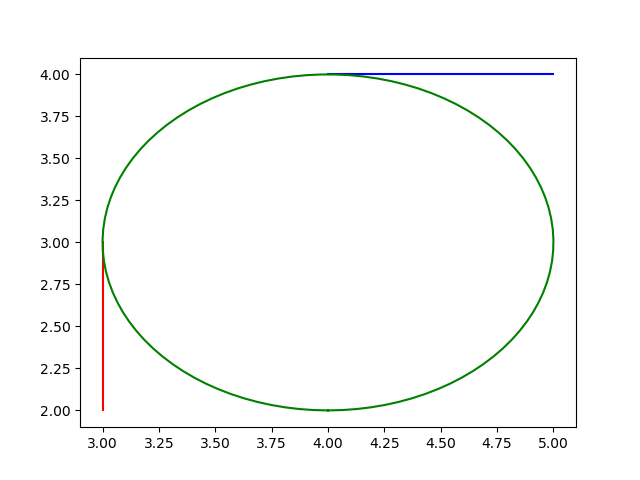

In [11]:
fig, ax = matplotlib.pyplot.subplots()

t_a = t_b = numpy.linspace(0, 1, 100)
t_e = numpy.linspace(0, 2 * numpy.pi, 100)

ax.plot(l_a(t_a)[0].flatten(), l_a(t_a)[1].flatten(), 'r')
ax.plot(l_b(t_b)[0].flatten(), l_b(t_b)[1].flatten(), 'b')

a, b, h, k = xs[-1][0], xs[-1][1], xs[-1][2], xs[-1][3]

ax.plot(ellipse(t_e, a, b, h, k)[0].flatten(), ellipse(t_e, a, b, h, k)[1].flatten(), 'g')

matplotlib.pyplot.show()

Perfect! There is an ellipse that smoothly connects these two roads.

## Issues

Unfortunately, this doesn't always work as smoothly. There are many ways to form roads that can not have an ellipse connecting them, even though a smooth turn does exist.

Let's now consider the roads defined by the fuctions

$$ \ell_a(t) = \left\langle 3 + \frac{t}{2}, \frac{5}{2} + t \right\rangle \quad \forall t \in [0, 1] $$
$$ \ell_b(t) = \langle 4 + t, 4 \rangle \quad \forall t \in [0, 1] $$

In [12]:
l_a = lambda t: numpy.array([[3 + t / 2], [2.5 + t]])
l_b = lambda t: numpy.array([[4 + t], [4 + 0 * t]])

The partial derivatives of these roads are easily determined by hand

$$ \frac{\partial \ell_a(t)}{\partial t} = \left\langle \frac{1}{2}, 1 \right\rangle \quad \forall t \in [0, 1] $$
$$ \frac{\partial \ell_b(t)}{\partial t} = \langle 1, 0 \rangle \quad \forall t \in [0, 1] $$

In [13]:
dl_adt = lambda t: numpy.array([[1/2], [1]])
dl_bdt = lambda t: numpy.array([[1], [0]])

Let's plot them to see if this is a meaningful intersection.

<IPython.core.display.Javascript object>


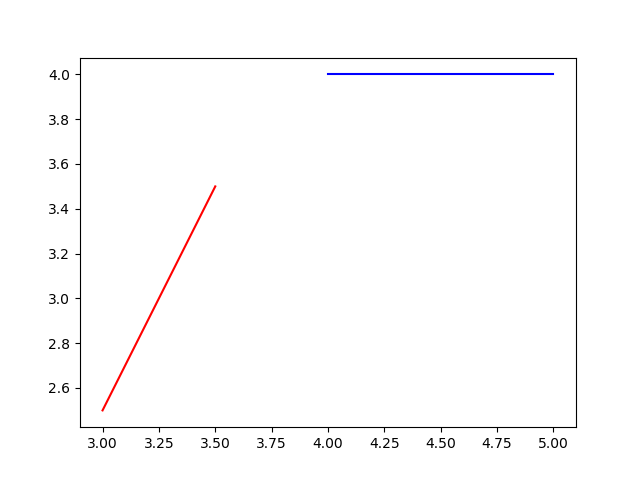

In [14]:
fig, ax = matplotlib.pyplot.subplots()

t_a = t_b = numpy.linspace(0, 1, 100)

ax.plot(l_a(t_a)[0].flatten(), l_a(t_a)[1].flatten(), 'r')
ax.plot(l_b(t_b)[0].flatten(), l_b(t_b)[1].flatten(), 'b')

matplotlib.pyplot.show()

Clearly, a smooth turn is possible between these two roads. Let's see if our method will determine it.

In [18]:
consts = numpy.vstack([l_a(1), l_b(0), dl_adt(1), dl_bdt(0)])
x_0 = numpy.random.randn(8, 1)

xs, Js, Fs = newtons_method(lambda x: F(numpy.vstack([x, consts])), lambda x: J(numpy.vstack([x, consts])), x_0, 0.01)

numpy.around(xs[-1], 3)

KeyboardInterrupt: 

Nope. Newton's method fails to converge. Let's confirm that moving the endpoint a little farther down will yield convergence. Instead of ending at $t_a = 1$, we will continue to $t_a = 1.01$.

In [19]:
consts = numpy.vstack([l_a(1.01), l_b(0), dl_adt(1.01), dl_bdt(0)])
x_0 = numpy.random.randn(8, 1)

xs, Js, Fs = newtons_method(lambda x: F(numpy.vstack([x, consts])), lambda x: J(numpy.vstack([x, consts])), x_0, 0.01)

numpy.around(xs[-1], 3)

array([[  2.487],
       [ 24.5  ],
       [  4.   ],
       [-20.5  ],
       [  1.771],
       [ -4.712],
       [ -4.875],
       [ -2.487]])

This time, Newton's method converged. Let's plot the solution to confirm its legitimacy.

<IPython.core.display.Javascript object>


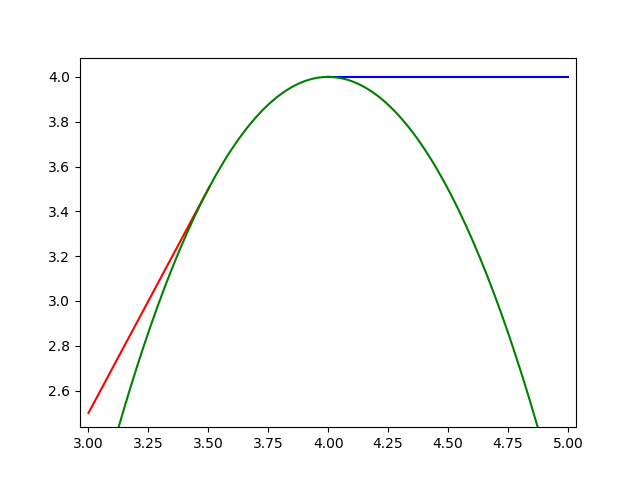

In [21]:
fig, ax = matplotlib.pyplot.subplots()

t_a = numpy.linspace(0, 1.01, 100)
t_b = numpy.linspace(0, 1, 100)
t_e = numpy.linspace(0, 2 * numpy.pi, 1000)

ax.plot(l_a(t_a)[0].flatten(), l_a(t_a)[1].flatten(), 'r')
ax.plot(l_b(t_b)[0].flatten(), l_b(t_b)[1].flatten(), 'b')

a, b, h, k = xs[-1][0], xs[-1][1], xs[-1][2], xs[-1][3]

ax.plot(ellipse(t_e, a, b, h, k)[0].flatten(), ellipse(t_e, a, b, h, k)[1].flatten(), 'g')

matplotlib.pyplot.show()

That certainly looks like a valid curve.

## Conclusion

This is unfortunate information. In order to apply this method, carefully selected endpoints must be chosen to yield convergence. However, I am not aware of a simple way to detect this issue or its fix. Thus, I will not be using this method.